# Option valuation model based on historical prices

In [37]:
from datetime import datetime, timedelta, date
import pandas
import binance
from data_cache import pandas_cache
import numpy
from numpy import ndarray
from matplotlib import pyplot
from matplotlib import ticker
import math
import requests

COUNT_YEARS = 10
BINANCE_DATETIME_FORMAT = "%Y-%m-%d %H-%M-%S"

SYMBOL = 'ETHUSDT'

@pandas_cache("code", "year")
def load_prices(client: binance.Client, code: str, year: int):
    from_date = datetime(year, 1, 1, 0, 0, 0)
    until_date = datetime(year + 1, 1, 1, 0, 0, 0) - timedelta(seconds=1)

    # Execute the query from binance - timestamps must be converted to strings !
    candles = client.get_historical_klines(code, binance.Client.KLINE_INTERVAL_1HOUR, str(from_date), str(until_date))

    # Create a dataframe to label all the columns returned by binance so we work with them later.
    df = pandas.DataFrame(candles, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime',
                                           'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol',
                                           'ignore'])

    # as timestamp is returned in ms, let us convert this back to proper timestamps.
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    df.dateTime = pandas.to_datetime(df.dateTime, unit='ms')
    df.set_index('dateTime', inplace=True)
    return df


# Create a client object
client = binance.Client()

current_year = datetime.now().year
df_years = list()
for year in range(current_year - COUNT_YEARS, current_year + 1):
    df = load_prices(client, SYMBOL, year)
    df = df.drop(['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'], axis=1)
    df_years.append(df)

prices_df = pandas.concat(df_years, axis=0)
prices_df.index = pandas.to_datetime(prices_df.index)

daily_prices = prices_df.groupby(prices_df.index.date)['open'].first()


## Input parameters here

In [40]:
TARGET_EXPIRY = date(2023, 9, 15)

remaining_days = (TARGET_EXPIRY - date.today()).days

instrument_code = 'ETH'
headers = {"Content-Type": "application/json"}
base_url = 'https://www.deribit.com/api/v2/public'
get_current_price = f"{base_url}/get_index_price?index_name=eth_usd"
response_current_price = requests.get(get_current_price, headers=headers)

if response_current_price.status_code != 200:
    raise IOError(f'request failed with error {response_current_price.status_code}')
    
current_price = response_current_price.json()['result']['index_price']

get_options = f"{base_url}/get_instruments?currency={instrument_code}&kind=option&expired=false"

response_options = requests.get(get_options, headers=headers)

if response_options.status_code != 200:
    raise IOError(f'request failed with error {response_options.status_code}')
    
result = response_options.json()['result']
puts = {}
calls = {}
for option in result:
    if option['option_type'] == 'put':
        puts[(option['strike'], datetime.fromtimestamp(option['expiration_timestamp'] / 1000).date())] = option['instrument_id']
    elif option['option_type'] == 'call':
        calls[(option['strike'], datetime.fromtimestamp(option['expiration_timestamp'] / 1000).date())] = option['instrument_id']


## Draw-down probability

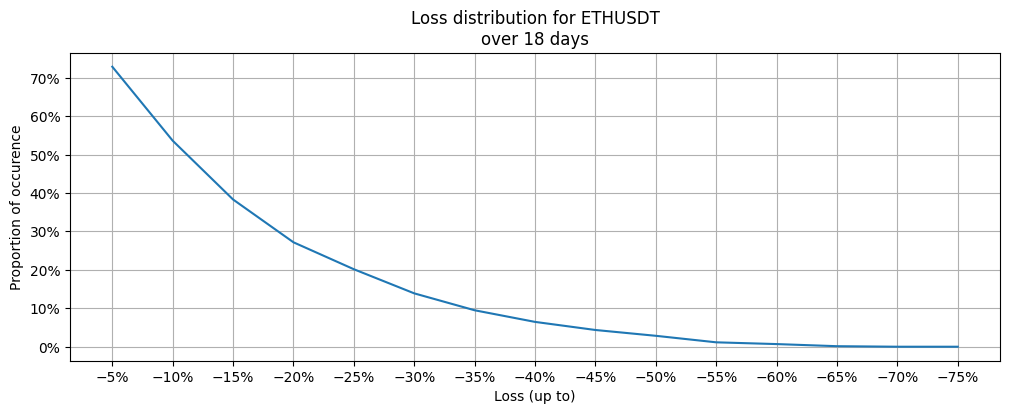

In [41]:
rolling_min_series = prices_df.groupby(prices_df.index.date)['low'].min().rolling(remaining_days).min()
period_close_series = prices_df.groupby(prices_df.index.date)['close'].last().shift(-remaining_days)
df = pandas.DataFrame({
    'daily_prices': daily_prices, 
    'period_close_series': period_close_series, 
    'rolling_min_series': rolling_min_series
})
df['rolling_min_series'] = df['rolling_min_series'].shift(-remaining_days)
df['drawdown_pct'] = -df['rolling_min_series'].divide(df['daily_prices']).subtract(1.).multiply(100.)
df['period_perf_pct'] = df['period_close_series'].divide(df['daily_prices']).subtract(1.).multiply(100.)
df.dropna(inplace=True)
df.index = pandas.to_datetime(df.index) 
frequencies = dict()
for loss in range(5, 80, 5):
    frequencies[-loss] = 100. * df['drawdown_pct'][df['drawdown_pct'] > loss].count() / df['drawdown_pct'].count()

df = df[df.index.year>=2019]    

from matplotlib import ticker
axes = pandas.Series(frequencies, name='loss_distribution').plot(
    figsize=(12,4),
    grid=True,
    xticks=list(frequencies.keys()),
    title=f'Loss distribution for {SYMBOL}\nover {remaining_days} days'
)
pyplot.gca().invert_xaxis()
pyplot.xlabel('Loss (up to)')
pyplot.ylabel('Proportion of occurence')
axes.xaxis.set_major_formatter(ticker.PercentFormatter())
axes.yaxis.set_major_formatter(ticker.PercentFormatter())

## Performance distribution

Text(0.5, 1.0, 'Period (18 days) Performance Underlying')

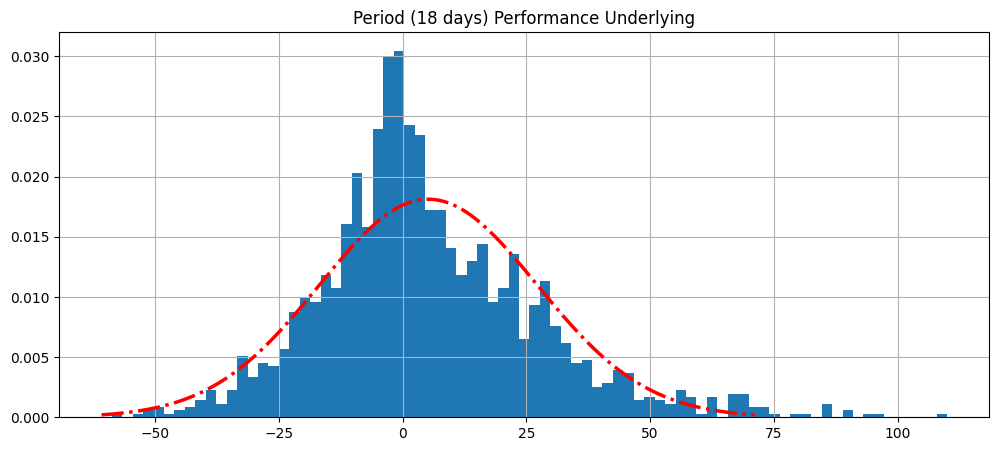

In [42]:
df['period_perf_pct'].hist(bins=80, density=True, figsize=(12, 5))

def normpdf(x: ndarray, mu: float, sigma: float):
    sigma = abs(float(sigma))
    z = (x - float(mu)) / sigma
    return numpy.array([math.exp(-0.5 * x * x) / (math.sqrt(2. * math.pi) * sigma) for x in z])


mu = df['period_perf_pct'].describe()['mean']
sigma = df['period_perf_pct'].describe()['std']
# Generate the normal distribution curve
x = numpy.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y = normpdf(x, mu, sigma)

# Plot the normal distribution curve
pyplot.plot(x, y, linestyle='dashdot', linewidth=2.5, color='red')
pyplot.title(f'Period ({remaining_days} days) Performance Underlying')

Text(0.5, 1.0, 'Daily Performance Underlying')

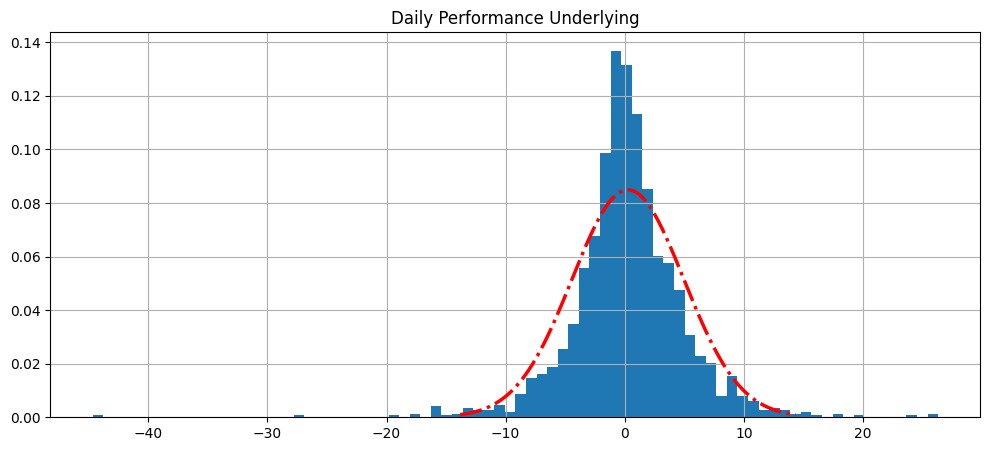

In [43]:
daily_perf = df["daily_prices"].shift(-1).divide(df["daily_prices"]).subtract(1.).dropna().multiply(100.)
daily_perf.hist(bins=80, density=True, figsize=(12, 5))

mu = daily_perf.describe()['mean']
sigma = daily_perf.describe()['std']
# Generate the normal distribution curve
x = numpy.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y = normpdf(x, mu, sigma)

# Plot the normal distribution curve
pyplot.plot(x, y, linestyle='dashdot', linewidth=2.5, color='red')
pyplot.title('Daily Performance Underlying')

## Option valuation model

<Axes: >

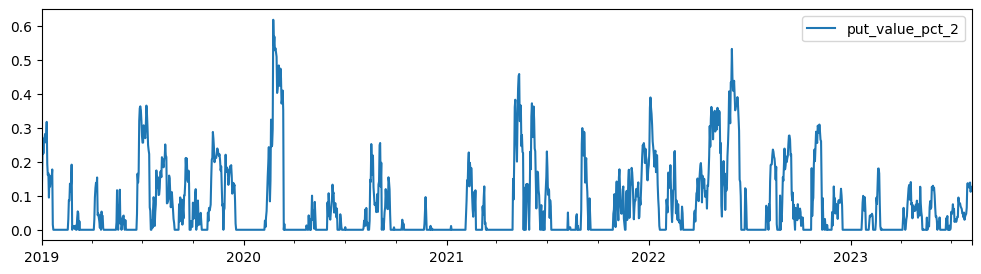

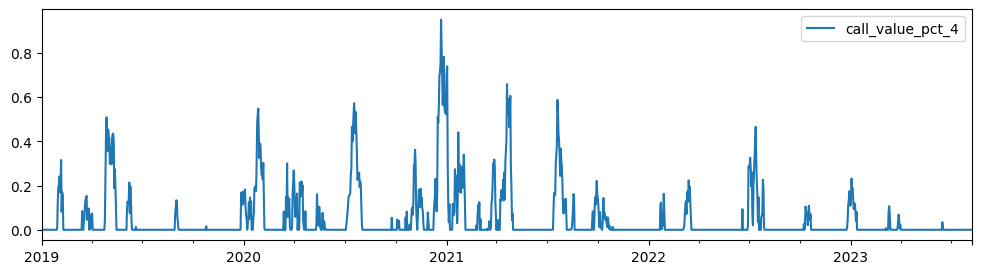

In [44]:
def generate_strikes(price: float):
    closest_hundred = round(price / 100.) * 100.
    strikes = set()
    strikes.add(closest_hundred)
    for i in range(1, 3):
        strikes.add(closest_hundred + i * 100.)
        strikes.add(closest_hundred - i * 100.)
        
    return strikes

strike_prices = list(generate_strikes(current_price))
for count, strike_price in enumerate(strike_prices, start=1):
    strike_factor = strike_price / current_price
    df[f'strike_{count}'] = df['daily_prices'].multiply(strike_factor)
    df[f'strike_pct_{count}'] = strike_factor
    
    df[f'call_value_{count}'] = df['period_close_series'].subtract(df[f'strike_{count}'])
    df[f'call_value_{count}'].loc[df[f'call_value_{count}'] < 0.] = 0.
    df[f'call_value_pct_{count}'] = df[f'call_value_{count}'].divide(df['daily_prices'])
    
    df[f'put_value_{count}'] = df[f'strike_{count}'].subtract(df['period_close_series'])
    df[f'put_value_{count}'].loc[df[f'put_value_{count}'] < 0.] = 0.
    df[f'put_value_pct_{count}'] = df[f'put_value_{count}'].divide(df['daily_prices'])
    

df[['put_value_pct_2']].plot(figsize=(12,3))
df[['call_value_pct_4']].plot(figsize=(12,3))


<Axes: >

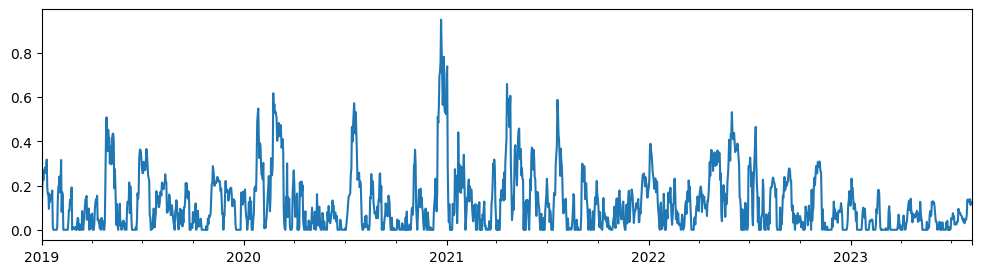

In [45]:
df['call_value_pct_4'].add(df['put_value_pct_2']).plot(figsize=(12,3))

In [46]:
option_chain = list()
for count, strike_price in enumerate(strike_prices, start=1):
    strike_data = {
        'strike': strike_price,
        'value_call': df[f'call_value_pct_{count}'].mean() * current_price,
        'value_put': df[f'put_value_pct_{count}'].mean() * current_price,
        'value_call_median': df[f'call_value_pct_{count}'].quantile(0.5) * current_price,
        'value_put_median': df[f'put_value_pct_{count}'].quantile(0.5) * current_price,
        'value_call_pct': df[f'call_value_pct_{count}'].mean(),
        'value_put_pct': df[f'put_value_pct_{count}'].mean()
    }
    if strike_price < current_price:
        strike_data['value_call_pct'] = None
    if strike_price > current_price:
        strike_data['value_put_pct'] = None
        
    option_chain.append(strike_data)
    
pandas.DataFrame(option_chain).set_index('strike').sort_index()

,value_call,value_put,value_call_median,value_put_median,value_call_pct,value_put_pct
strike,,,,,,
1500.0,279.691490,42.859255,181.062852,0.000000,NaN,0.025953
1600.0,208.847323,72.015088,81.062852,0.000000,NaN,0.043608
1700.0,153.763612,116.931377,0.000000,18.937148,0.093111,NaN
1800.0,112.709493,175.877257,0.000000,118.937148,0.068250,NaN
1900.0,81.065750,244.233514,0.000000,218.937148,0.049089,NaN


In [49]:
instrument_id = puts[(1600, TARGET_EXPIRY)]

get_bid_ask = f"{base_url}/get_order_book_by_instrument_id?instrument_id={instrument_id}&depth=1"
response_bid_ask = requests.get(get_bid_ask, headers=headers)

if response_bid_ask.status_code != 200:
    raise IOError(f'request failed with error {response_bid_ask.status_code}')

bid_ask = response_bid_ask.json()['result']
bid, ask = bid_ask['bids'][0][0], bid_ask['asks'][0][0]
bid, ask

(0.0145, 0.015)

In [20]:
df[f'call_value_pct_3'].describe()

count    1677.000000
mean        0.080152
std         0.152789
min         0.000000
25%         0.000000
50%         0.000000
75%         0.104264
max         1.015336
Name: call_value_pct_3, dtype: float64

<Axes: title={'center': 'EWM 120 days price'}>

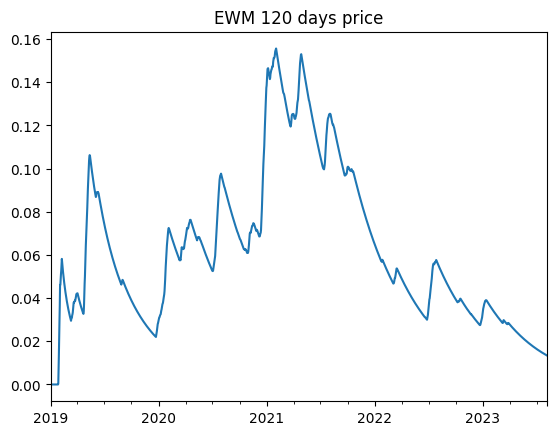

In [21]:
df[f'call_value_pct_4'].ewm(halflife='120 days', times=df.index).mean().plot(title='EWM 120 days price')

<Axes: >

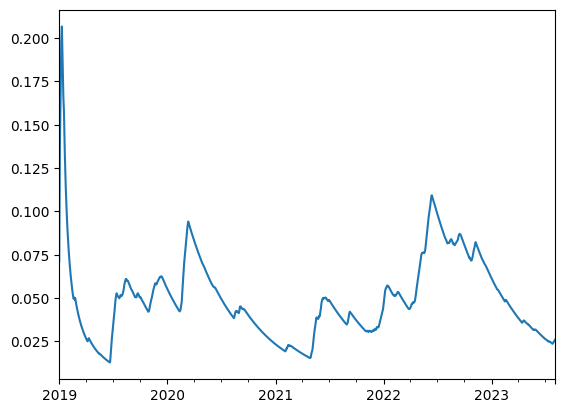

In [22]:
df[f'put_value_pct_1'].ewm(halflife='120 days', times=df.index).mean().plot()

In [34]:

bid, ask = bid_ask['bids'][0][0], bid_ask['asks'][0][0]